                        Project done by Michela Pirozzi MAT:732531 and Sara Ferioli MAT:733105

# LAB 3

## Goal

* Given the features in the dataset, what is the best combination to have a new contract? 
Was the feature combination the same even before covid?

* Predict number of contracts.
Is the number of contracts predicted for the future in 2019 the same or similar to the actual data given the occurrence of COVID? 

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import data and analysis

In [2]:
# Load the dataset
transformed = pd.read_csv('transformed.csv')
transformed = transformed.drop(labels='Unnamed: 0', axis=1)
transformed

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
0,60,2020-05,2020,188,0,1,32612
1,33,2012-07,2012,81,0,1,32591
2,45,2019-04,2019,89,0,1,32612
3,61,2014-09,2014,188,0,1,32618
4,20,2014-05,2014,89,0,1,32597
...,...,...,...,...,...,...,...
9317598,36,2012-07,2012,89,0,0,1349
9317599,35,2011-07,2011,89,0,0,1350
9317600,27,2009-04,2009,89,0,0,1351
9317601,37,2012-06,2012,89,0,0,1349


### Balancing

In [3]:
# Check if the dataset is balanced
transformed["contratto_transformed"].value_counts(normalize=True)

0    0.854901
1    0.145099
Name: contratto_transformed, dtype: float64

We notice that the dataset is not balanced basing on the type of contract

In [4]:
# Count the occurencies of INDETERMINATO's contracts
transformed[transformed["contratto_transformed"]==1].count()

ETA                        1351972
mese-anno                  1351972
ANNO                       1351972
nazionalita_transformed    1351972
contratto_transformed      1351972
genere_transformed         1351972
Output_transformed         1351972
dtype: int64

In [5]:
# Count the occurencies of NON INDETERMINATO's contracts
transformed[transformed["contratto_transformed"]==0].count()

ETA                        7965631
mese-anno                  7965631
ANNO                       7965631
nazionalita_transformed    7965631
contratto_transformed      7965631
genere_transformed         7965631
Output_transformed         7965631
dtype: int64

#### Random Undersampling

We use undersampling instead of oversampling because we care more about the INDETERMINATO's contracts which have less occurencies, even if there are the possibilities to lose some informations.

In [6]:
# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = transformed[transformed["contratto_transformed"]==0].sample(n=1351972,random_state=16) 
data_1 = transformed[transformed["contratto_transformed"]==1]
balanced = data_0.append(data_1)
balanced

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
4953445,25,2014-11,2014,89,0,1,13966
3994675,46,2011-12,2011,89,0,0,13797
3182761,24,2016-01,2016,144,0,0,6674
6623019,38,2020-07,2020,89,0,1,26059
2404077,32,2012-05,2012,89,0,1,26698
...,...,...,...,...,...,...,...
9317581,26,2019-02,2019,89,1,1,18030
9317583,28,2014-09,2014,89,1,1,18031
9317591,33,2009-01,2009,89,1,0,18036
9317593,34,2021-08,2021,89,1,0,18031


In [7]:
# Check if the dataset is balanced
balanced["contratto_transformed"].value_counts(normalize=True)

0    0.5
1    0.5
Name: contratto_transformed, dtype: float64

## Create the train and test sets

In [8]:
# Create the train and test sets
X = balanced[["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"]].values
y = pd.DataFrame(balanced['Output_transformed'].copy()).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [9]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
X_train=X_train.astype(np.uint8)
y_train=y_train.astype(np.uint8)

## Decision Tree

### Find the best max_depth

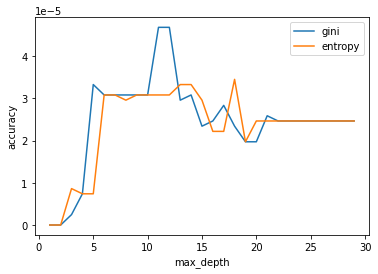

In [10]:
# Find the max depth neccessary for the Decision tree
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
     dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
     dtree.fit(X_train, y_train)
     pred = dtree.predict(X_test)
     acc_gini.append(accuracy_score(y_test, pred))
     ####
     dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
     dtree.fit(X_train, y_train)
     pred = dtree.predict(X_test)
     acc_entropy.append(accuracy_score(y_test, pred))
     ####
     max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

We notice that the best accuracy is when max_depth is (more or less) equal to 10.

### Execution of Decision Tree

In [11]:
# Method that allow to calculate the decision tree
# syntax:
# X_train: input train dataframe
# y_train: output train dataframe
def dct(X_train, y_train):
    dct = tree.DecisionTreeClassifier()
    
    DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           class_weight=None)
    
    return dct

In [12]:
# Create Decision tree and fit it
dct = dct(X_train, y_train)
dct.fit(X_train, y_train)

DecisionTreeClassifier()

In [13]:
# With the following sintax we will create a .dot file with the code for visualizing th tree
tree.export_graphviz(dct, out_file='tree.dot', feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"])

In [ ]:
# Show Decision tree
tree.plot_tree(dct)

[Text(0.47719219505908805, 0.9861111111111112, 'X[3] <= 61.5\ngini = 0.994\nsamples = 1892760\nvalue = [3295, 2750, 16838, 5142, 3970, 12468, 3663, 2835, 3465\n3711, 3527, 7168, 3475, 3696, 6696, 2920, 6340, 12934\n12359, 8428, 6052, 5448, 5579, 5164, 2430, 3181, 10154\n4122, 7409, 3682, 3842, 3637, 4719, 4662, 5377, 8586\n10932, 5802, 7438, 6911, 15149, 8786, 5046, 6027\n10506, 6712, 7720, 3857, 5679, 4046, 4080, 3406, 8606\n3012, 5218, 4158, 9548, 3866, 3815, 4831, 4445, 8284\n8146, 12839, 6961, 8635, 24295, 7510, 6773, 15271\n12488, 20225, 10133, 9721, 16238, 4355, 6596, 2467\n1706, 47784, 15456, 3807, 8494, 4964, 5731, 5957, 4844\n5826, 44202, 10284, 21794, 3415, 5579, 10930, 6254\n6503, 5662, 3880, 4868, 4151, 9555, 7188, 8022, 6055\n23796, 7486, 4434, 3606, 3534, 13915, 4562, 7247\n10732, 9771, 4252, 3493, 3728, 4594, 3492, 5609, 10094\n4983, 6174, 6607, 4288, 9326, 5409, 6262, 10816, 5660\n6929, 4303, 8357, 8072, 5053, 4243, 12982, 9033, 19399\n3058, 10895, 5437, 14166, 3882, 86

In [14]:
# Probablistic prediction the values
y_pred_prob = dct.predict_proba(X_test)
y_pred_prob

array([[0.00239234, 0.00717703, 0.00239234, ..., 0.        , 0.        ,
        0.        ],
       [0.00104822, 0.00209644, 0.00733753, ..., 0.00419287, 0.        ,
        0.00104822],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00274725, 0.00824176, ..., 0.00274725, 0.00274725,
        0.00549451],
       [0.00197628, 0.00197628, 0.00790514, ..., 0.00197628, 0.01581028,
        0.00395257],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [15]:
# Predict the values
y_pred_all = dct.predict(X_test)
y_pred_all

array([ 79, 120,  51, ...,  79, 186,  26], dtype=uint8)

#### Confusion matrix

In [16]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred_all=y_pred_all.astype(np.uint8)

# Print the confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred_all)
print(confusion)

[[  2   3  36 ...   1   2   1]
 [  2   2  31 ...   0   4   0]
 [ 43  15 466 ...   1  11   1]
 ...
 [  5   3  67 ...   2   8   0]
 [  6   0  52 ...   2 152   2]
 [  1   0  28 ...   0  10  15]]


### Best Depth Tree

In [17]:
# Calculate the max depth in the decision tree
max_depth = dct.get_depth()
max_depth

35

In [18]:
# Find the best parameter
max_depth_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                                    scoring=make_scorer(accuracy_score),
                                    param_grid=ParameterGrid({"max_depth":[[max_depth] for max_depth in range(1, max_depth+1)]}),)
max_depth_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x7fd8bd0957d0>,
             scoring=make_scorer(accuracy_score))

In [19]:
# Show the best parameter
max_depth_grid_search.best_params_

{'max_depth': 13}

In [ ]:
# Show the tree with the parameter found previuosly 
best_max_depth_tree=max_depth_grid_search.best_estimator_
best_max_depth = best_max_depth_tree.get_depth()

plt.figure(figsize=(4,4), dpi=1000)
plot_tree(best_max_depth_tree,
         feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"],
          filled=True,)
plt.show()

### Prune the tree

The following parts we were not able to execute because they took too long (we never got an output). 
They are for pruning the tree, a technique used to reduce or avoid overfitting.

#### Pre-Pruning

Pre pruning is nothing but stoping the growth of decision tree on an early stage. 

In [ ]:
# Set parameters and prune the tree
grid_param={"criterion":["gini","entropy"],
             "splitter":["best","random"],
             "max_depth":range(2,50,1),
             "min_samples_leaf":range(1,15,1),
             "min_samples_split":range(2,20,1) 
            }
grid_search=GridSearchCV(estimator=dct,param_grid=grid_param,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)

In [ ]:
# Print the best parameters
print(grid_search.best_params_)

In [ ]:
# Show the tree
clf=DecisionTreeClassifier(criterion= 'gini',max_depth= 10,min_samples_leaf= 3,min_samples_split= 12,splitter= 'random')
clf.fit(X_train,y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(clf,rounded=True,filled=True)
plt.show()

In [ ]:
# Predict the values
y_pred=clf.predict(X_test)
accuracy_score(y_test,y_pred)

#### Post pruning techniques

##### Cost Complexity Pruning

Method to improve test accuracy and get a better model.

In [ ]:
# Finding the right parameter for alpha
path = dct.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [ ]:
# Show the dependence bewteen the alpha value and the number of nodes
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

##  K-Nearest Neighbors Classification

In [20]:
# Method that allow to scaled the features
# syntax:
# data_train: train dataframe
# data_test: test dataframe
def scaleFeaturesDF(data_train, data_test):

    transf = preprocessing.MinMaxScaler().fit(data_train)
    data_train = transf.transform(data_train)
    data_train = pd.DataFrame(data_train)
    data_test = transf.transform(data_test)
    data_test = pd.DataFrame(data_test)
    
    
    return data_train, data_test

In [21]:
# Apply the function 
[X_train, X_test]=scaleFeaturesDF(X_train, X_test)

In [22]:
# Find the model of K-Nearest Neighbors and fit it
knmodel = KNeighborsClassifier(n_neighbors =5, weights='uniform')
knmodel.fit(X_train, y_train)

KNeighborsClassifier()

In [23]:
# Predict using KNN
y_pred = knmodel.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = sqrt(mse)
rmse

9.947309249499785

### Confusion Matrix

In [24]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred=y_pred.astype(np.uint8)

# Print the confusion matrix
confusion = metrics.confusion_matrix(y_train, y_pred)
print(confusion)

[[ 353   23  116 ...    1    3    0]
 [  29  372   81 ...    1    5    0]
 [ 185  104 3842 ...    3    4    0]
 ...
 [  26   29  150 ...   29    6    0]
 [ 108   62  251 ...    2  206    3]
 [  32   30  149 ...    0    7   18]]


## Future Prediction

### ARIMA

Prediction of the number of activated contracts wiht Autoregressive integrated moving average model.

In [25]:
# Load the dataset
balanced
bal1 = balanced.copy()
bal1 = bal1.reset_index(drop=True)
bal1

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
0,25,2014-11,2014,89,0,1,13966
1,46,2011-12,2011,89,0,0,13797
2,24,2016-01,2016,144,0,0,6674
3,38,2020-07,2020,89,0,1,26059
4,32,2012-05,2012,89,0,1,26698
...,...,...,...,...,...,...,...
2703939,26,2019-02,2019,89,1,1,18030
2703940,28,2014-09,2014,89,1,1,18031
2703941,33,2009-01,2009,89,1,0,18036
2703942,34,2021-08,2021,89,1,0,18031


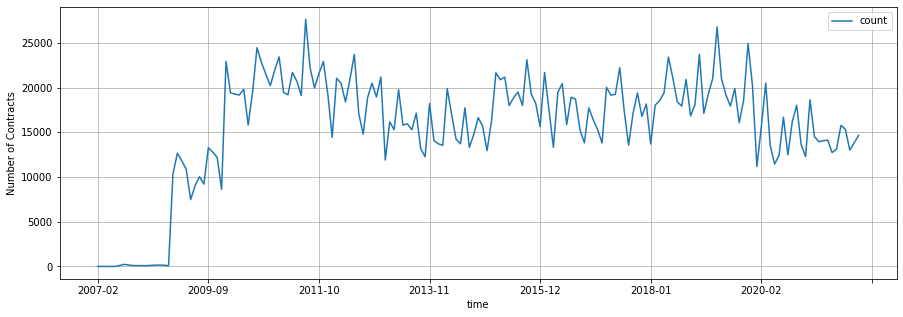

In [26]:
# Set mese-anno like index
# Show count of contract for each mese-anno
bal2 = bal1.groupby("mese-anno").size().reset_index(name='count')
bal2 = bal2.set_index('mese-anno')
f, ax1 = plt.subplots(1,1,figsize=(15,5))
bal2.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")
plt.grid(True)

In [27]:
# Calculate the Augmented Dickey-Fuller test can be used to test for a unit root in a univariate 
#process in the presence of serial correlation.
results = adfuller(bal2['count'])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -4.621934
p-value: 0.000118


In [29]:
# Show seasonality and trend
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(bal2, model="additive", period=5)

fig, ax = plt.subplots(4, 1, figsize=(15, 8))
# Plot the series
decomposed_add.observed.plot(ax = ax[0])
decomposed_add.trend.plot(ax = ax[1])
decomposed_add.seasonal.plot(ax = ax[2])
decomposed_add.resid.plot(ax = ax[3])
# Add the labels to the Y-axis
ax[0].set_ylabel('')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

AttributeError: ignored

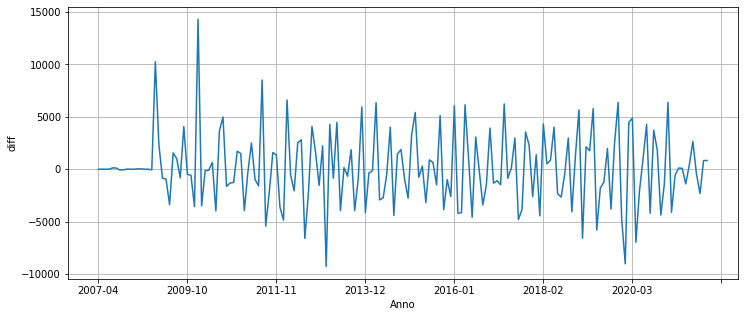

In [30]:
# Calculate differential
bal_diff = bal2['count'].diff().dropna()
plt.figure(figsize=(12,5))
ax1 = bal_diff.plot()
ax1.set_xlabel("Anno")
ax1.set_ylabel("diff")
plt.grid(True)
plt.show()

In [31]:
# Calculate the Augmented Dickey-Fuller test

results = adfuller(bal_diff)
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -2.966888
p-value: 0.038105


In [32]:
# Calculate the Augmented Dickey-Fuller test
results = adfuller(bal2['count'].diff().diff().dropna())
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -7.803319
P-value of a test is: 7.39348960457249e-12


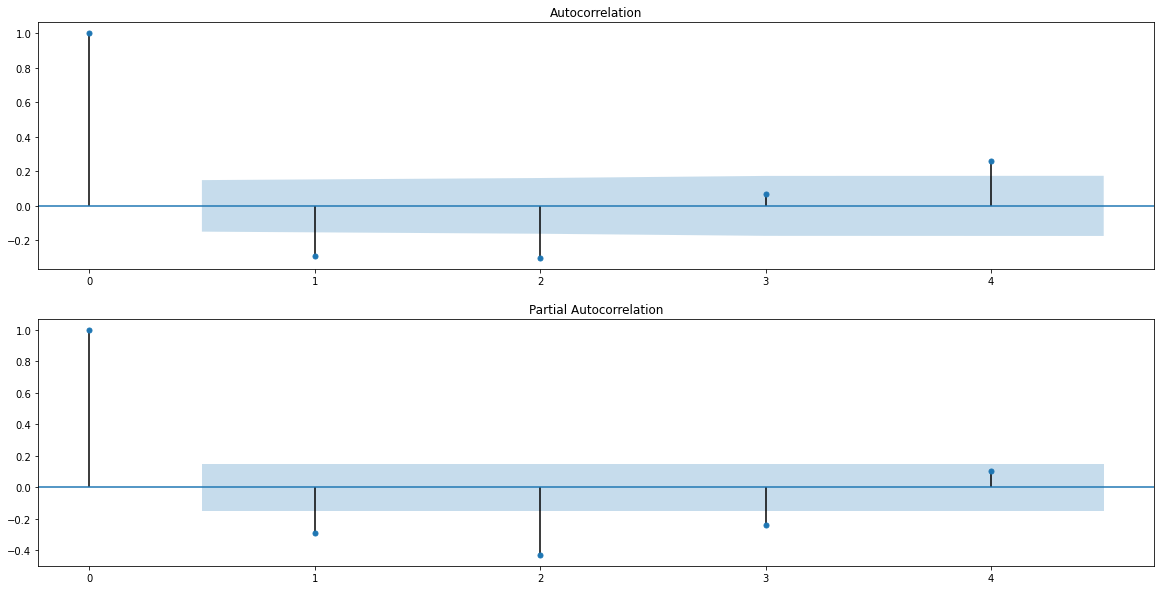

In [33]:
# Show autocorrelation and partial correlation
fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(bal_diff, lags=4, ax=ax[0])
plot_pacf(bal_diff, lags=4, ax=ax[1])
plt.show()

In [34]:
# Search p and q values

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-5
for p in range(4):
    # Loop over q values from 0-5
    for q in range(4):
        
        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(bal2['count'].astype(float), order=(p,1,q))
            results = model.fit()
            
            # Printing order, AIC and BIC
            #print(p, q, results.aic, results.bic)
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            #print(p, q, None, None)
            i = i+1
    
arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="aic", ascending=False, inplace=True)
arima_df

,p,q,aic,bic,sum_aic_bic
0,0,0,3301.087405,3307.382394,6608.4698
4,1,0,3287.967076,3297.409559,6585.376635
1,0,1,3259.307437,3268.74992,6528.057357
5,1,1,3259.262288,3271.852265,6531.114553
6,1,2,3257.405645,3273.143118,6530.548763
2,0,2,3257.037376,3269.627354,6526.66473
8,2,0,3256.403783,3268.993761,6525.397544
10,2,2,3252.456276,3271.341243,6523.79752
7,1,3,3250.918845,3269.803812,6520.722657
9,2,1,3250.498003,3266.235475,6516.733477


Best AIC value with p=3 and q=3

In [35]:
# Compute the model
model2 = SARIMAX(bal2, order=(3,1,3), seasonal_order=(0,1,0,6))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             count   No. Observations:                  173
Model:             SARIMAX(3, 1, 3)x(0, 1, 0, 6)   Log Likelihood               -1594.211
Date:                           Fri, 20 May 2022   AIC                           3202.422
Time:                                   14:24:18   BIC                           3224.206
Sample:                                        0   HQIC                          3211.264
                                           - 173                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6117      0.133     -4.591      0.000      -0.873      -0.351
ar.L2         -0.8416      0.103     -8.144      0.000      -1.044      -0.639
ar.L3         -0.1047      0.125     -0.835      0.404      -0.350       0.141
ma.L1          0.1415      0.086      1.637      0.102      -0.028       0.311
ma.L2          0.2026      0.078      2.602      0.009       0.050       0.355
ma.L3         -0.7853      0.082     -9.592      0.000      -0.946      -0.625
sigma2      1.564e+07   1.48e-09   1.05e+16      0.000    1.56e+07    1.56e+07
===================================================================================
Ljung-Box (Q):                       81.77   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               0.79   Skew:                             0.08
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.59e+32. Standard errors may be unstable.
"""

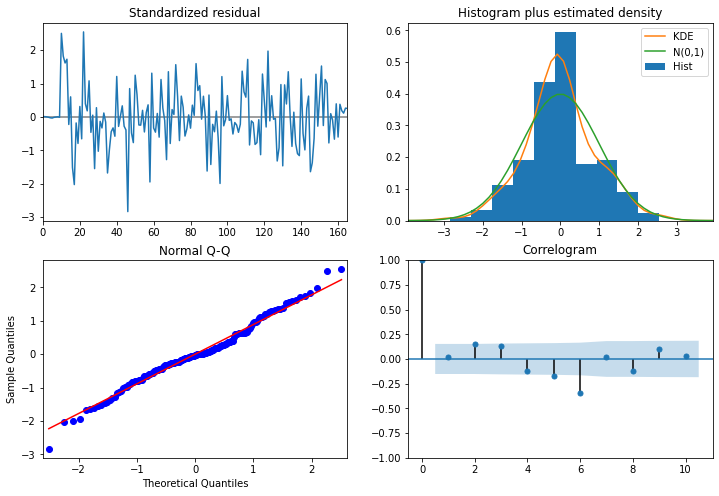

In [36]:
# Show the parameters
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()

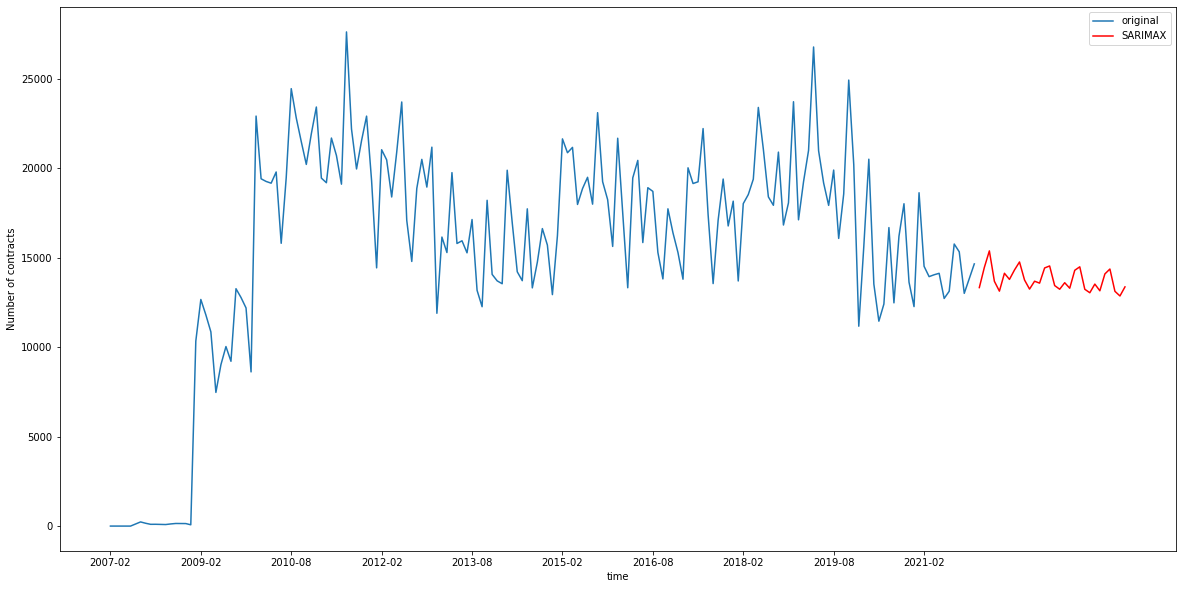

In [37]:
# Prediction of the future

# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(bal2, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")

plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)

plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.legend()
plt.show()

## Model Validation

### Featuring engineering

In [38]:
# Featuring engineering
# Lag features and Shift index
for i in range(1,3):
    lag_i = 'lag_' + str(i)
    bal2[lag_i] = bal2['count'].shift(i)
    
# Rolling window
bal2['rolling_mean'] = bal2['count'].rolling(window=2).mean()
bal2['rolling_max'] = bal2['count'].rolling(window=2).max()
bal2['rolling_min'] = bal2['count'].rolling(window=2).min()

### Feature Correlation 

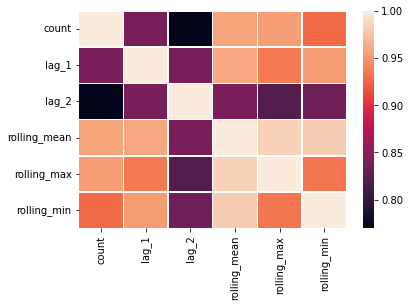

In [39]:
# Show the feature correlation
corr = bal2.corr()
fig = plt.figure(figsize=(6,4))
sns.heatmap(corr, linewidths=.5)

In [40]:
# Count is less correlated with lag_1 and lag_2. We removing them from dataset.
bal2 = bal2[["rolling_mean","rolling_max", "rolling_min", "count"]]
print('Shape:', bal2.shape)
bal2.head()

Shape: (173, 4)


,rolling_mean,rolling_max,rolling_min,count
mese-anno,,,,
2007-02,NaN,NaN,NaN,2
2007-04,1.5,2.0,1.0,1
2007-06,1.0,1.0,1.0,1
2007-10,1.0,1.0,1.0,1
2007-11,1.0,1.0,1.0,1


In [41]:
# Fill NaN values with mean value
bal2.fillna(bal2.mean(), inplace = True)
bal2.head()

,rolling_mean,rolling_max,rolling_min,count
mese-anno,,,,
2007-02,15677.985465,16997.05814,14358.912791,2
2007-04,1.500000,2.00000,1.000000,1
2007-06,1.000000,1.00000,1.000000,1
2007-10,1.000000,1.00000,1.000000,1
2007-11,1.000000,1.00000,1.000000,1


In [42]:
# Show the dimension of the dataset to calculate the train and the test
bal2.shape

(173, 4)

In [43]:
# Split the time series data (Train-80, Test-20)
print('Total records in dataset:', len(bal2))
contract_train = bal2.iloc[0:138]               
contract_test = bal2.iloc[138:]

contract_pred_train = bal2.iloc[0:138]               
contract_pred_test = bal2.iloc[138:]
print('Total records in Training set:', len(contract_train))
print('Total records in Test set:', len(contract_test))

Total records in dataset: 173
Total records in Training set: 138
Total records in Test set: 35


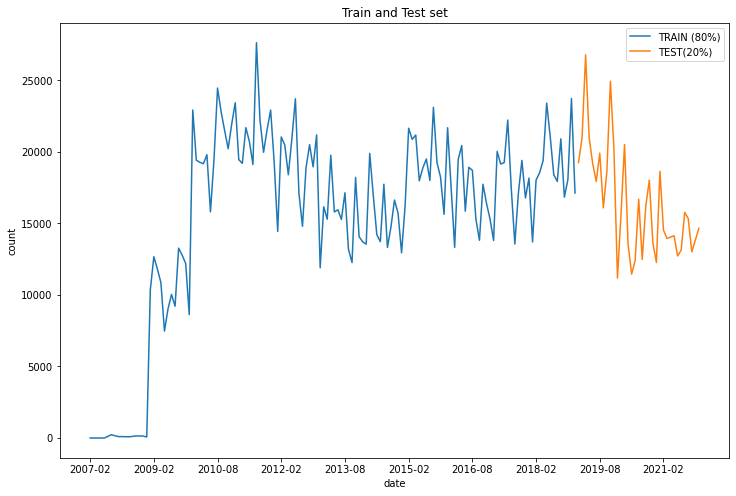

In [44]:
# Plot train and test sets
plt.plot(contract_train['count'],label='TRAIN (80%)')
plt.plot(contract_test['count'], label='TEST(20%)')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Train and Test set')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

In [45]:
# Delete the feature to predict
X_train = contract_train.drop(['count'], axis=1)
y_train = contract_train['count'].values

X_test = contract_test.drop(['count'], axis=1)
y_test = contract_test['count'].values

In [46]:
# Delete the feature to predict
X_pred_train = contract_pred_train.drop(['count'], axis=1)
y_pred_train = contract_pred_train['count'].values

X_pred_test = contract_pred_test.drop(['count'], axis=1)
y_pred_test = contract_pred_test['count'].values

### Holt winter

Holt-Winters forecasting is a way to model and predict the behavior of a sequence of values over time—a time series.
Holt-Winters is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality).

In [47]:
# Modeling the simple exponential smoothing
ses_model = SimpleExpSmoothing(contract_train['count']).fit(smoothing_level=0.3)
ses_preds = ses_model.forecast(steps = 35) 

In [48]:
# Calculate the errors
ses_errors_df = contract_test[['count']]
ses_errors_df['Predicted_Count'] = ses_preds.values
ses_errors_df['Error'] = ses_preds.values - y_test
ses_errors_df.insert(0, 'Modelname', 'Holtman- SES')

In [49]:
# Modeling the double exponential smoothing
double_model = ExponentialSmoothing(contract_train['count'],trend='add').fit()
doublemodel_preds = double_model.forecast(35).rename('DES Forecast')

In [50]:
# Calculate the errors
des_errors_df = contract_test[['count']]
des_errors_df['Predicted_Count'] = doublemodel_preds.values
des_errors_df['Error'] = doublemodel_preds.values - y_test
des_errors_df.insert(0, 'Modelname', 'Holtman- DES')
des_errors_df.head()

,Modelname,count,Predicted_Count,Error
mese-anno,,,,
2019-02,Holtman- DES,19251,19537.045553,286.045553
2019-03,Holtman- DES,21004,19678.542400,-1325.457600
2019-04,Holtman- DES,26785,19820.039247,-6964.960753
2019-05,Holtman- DES,20982,19961.536094,-1020.463906
2019-06,Holtman- DES,19182,20103.032941,921.032941


In [51]:
# Modeling the triple exponential smoothing
triple_model = ExponentialSmoothing(contract_train['count'],trend='add', seasonal= 'mul',seasonal_periods= 12).fit(use_boxcox=False, remove_bias=False)
tes_forecast = triple_model.forecast(35).rename('TES_Forecast')

In [52]:
# Calculate the errors
tes_errors_df = contract_test[['count']]
tes_errors_df['Predicted_Count'] = tes_forecast.values
tes_errors_df['Error'] = tes_forecast.values - y_test
tes_errors_df.insert(0, 'Modelname', 'Holtman- TES')
tes_errors_df.head()

,Modelname,count,Predicted_Count,Error
mese-anno,,,,
2019-02,Holtman- TES,19251,19450.428058,199.428058
2019-03,Holtman- TES,21004,20145.026336,-858.973664
2019-04,Holtman- TES,26785,21131.459707,-5653.540293
2019-05,Holtman- TES,20982,25361.355856,4379.355856
2019-06,Holtman- TES,19182,22958.482029,3776.482029


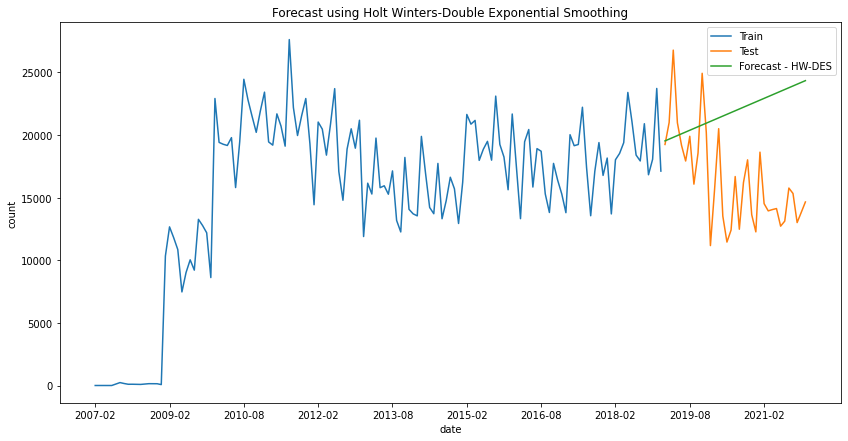

In [53]:
# Plot the number of contract using holtman forecast model using Double Exponential Smoothing
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(des_errors_df.index, des_errors_df['Predicted_Count'], label='Forecast - HW-DES')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Forecast using Holt Winters-Double Exponential Smoothing')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

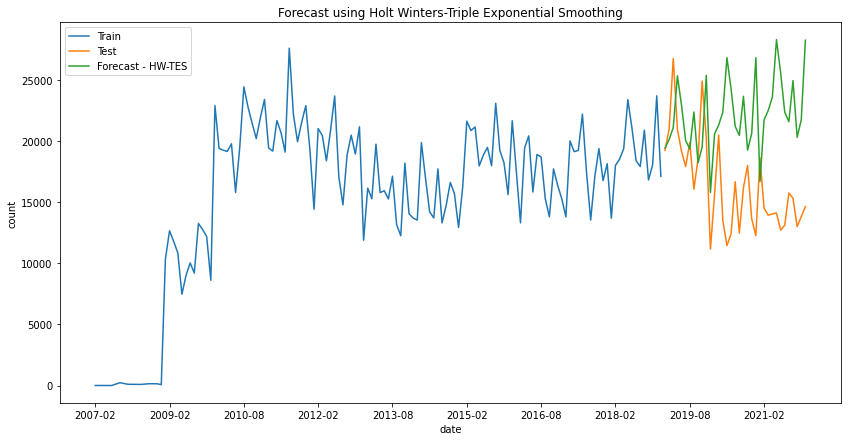

In [54]:
# Plot the number of contract using holtman forecast model using Triple Exponential Smoothing
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(tes_errors_df.index, tes_errors_df['Predicted_Count'], label='Forecast - HW-TES')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Forecast using Holt Winters-Triple Exponential Smoothing')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### Extra trees regressor

* Composed of a large number of decision trees, where the final decision is obtained taking into account the prediction of every tree
* When selecting the partition of each node, randomly choose a subset of features

In [55]:
# Fit model
etr_model = ExtraTreesRegressor(n_estimators=100)
etr_model.fit(X_train, y_train)

ExtraTreesRegressor()

In [57]:
# Start the prediction
etr_preds = etr_model.predict(X_test)
print('Prediction is done..')

Prediction is done..


In [58]:
# Check the score for the train and test sets
print('Model Score at Train set: {:.2%}'.format(etr_model.score(X_train, y_train)))
print('Model Score at Test set: {:.2%}'.format(etr_model.score(X_test, y_test)))

Model Score at Train set: 100.00%
Model Score at Test set: 63.03%


In [59]:
# Calculate the errors
etr_errors_df = contract_test[['count']]
etr_errors_df['Predicted_Count'] = etr_preds
etr_errors_df['Error'] = etr_preds - y_test
etr_errors_df.insert(0, 'Modelname', 'ExtreeTreesRegressor')
etr_errors_df.head()

,Modelname,count,Predicted_Count,Error
mese-anno,,,,
2019-02,ExtreeTreesRegressor,19251,18794.93,-456.07
2019-03,ExtreeTreesRegressor,21004,20858.85,-145.15
2019-04,ExtreeTreesRegressor,26785,24259.78,-2525.22
2019-05,ExtreeTreesRegressor,20982,24364.33,3382.33
2019-06,ExtreeTreesRegressor,19182,20750.92,1568.92


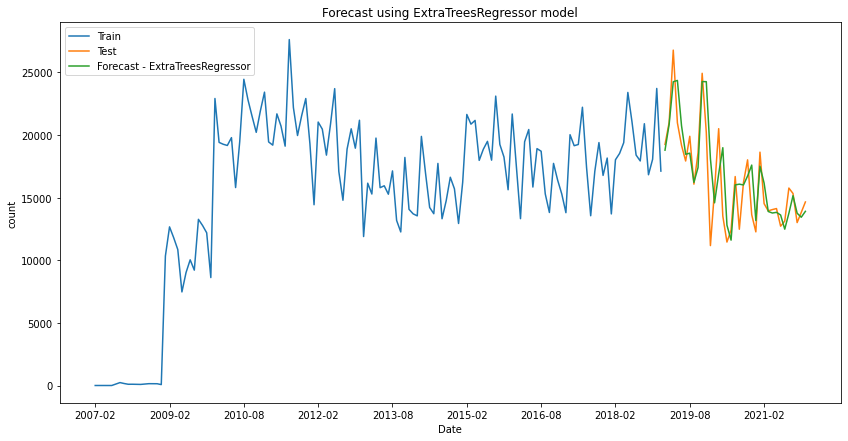

In [60]:
# Show the predictions for Extra Tree Regressor
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(etr_errors_df.index, etr_errors_df['Predicted_Count'], label='Forecast - ExtraTreesRegressor')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using ExtraTreesRegressor model')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### Linear regression

Model for understanding the relationship between input and output numerical variables. 

In [61]:
# Fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [62]:
# Start the prediction
lr_preds = lr_model.predict(X_test)
print('Prediction is done..')

Prediction is done..


In [63]:
# Calculate the errors
lr_errors_df = contract_test[['count']]
lr_errors_df['Predicted_Count'] = lr_preds
lr_errors_df['Error'] = lr_preds - y_test
lr_errors_df.insert(0, 'Modelname', 'Linear Regression')
lr_errors_df.head()

,Modelname,count,Predicted_Count,Error
mese-anno,,,,
2019-02,Linear Regression,19251,17931.072700,-1319.927300
2019-03,Linear Regression,21004,19705.060243,-1298.939757
2019-04,Linear Regression,26785,24296.921678,-2488.078322
2019-05,Linear Regression,20982,24291.663278,3309.663278
2019-06,Linear Regression,19182,19672.687868,490.687868


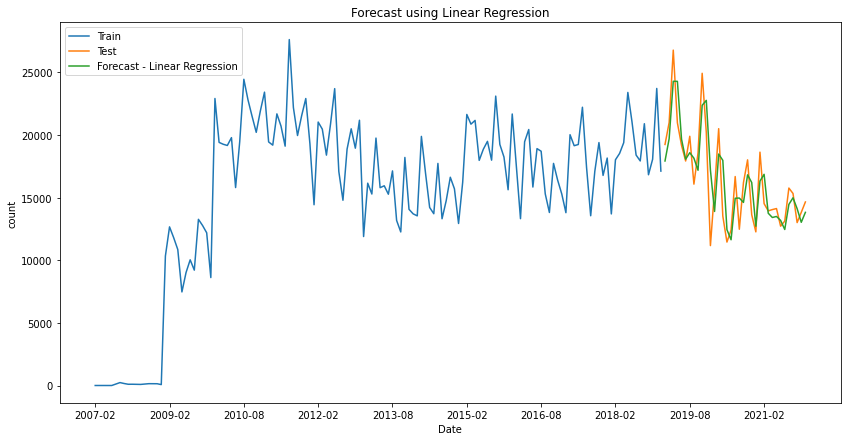

In [64]:
# Show the predictions for Linear Regression
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(lr_errors_df.index, lr_errors_df['Predicted_Count'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using Linear Regression')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### ARIMA e SARIMAX

In [65]:
# Fit the model
arima_model = ARIMA(bal2['count'], (3,1,3)).fit(disp=False)
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                  172
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1614.777
Method:                       css-mle   S.D. of innovations           2883.246
Date:                Fri, 20 May 2022   AIC                           3245.555
Time:                        14:26:53   BIC                           3270.735
Sample:                             1   HQIC                          3255.771
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            83.8925     91.061      0.921      0.358     -94.583     262.368
ar.L1.D.count    -1.0200      0.216     -4.722      0.000      -1.443      -0.597
ar.L2.D.count    -0.7932      0.135     

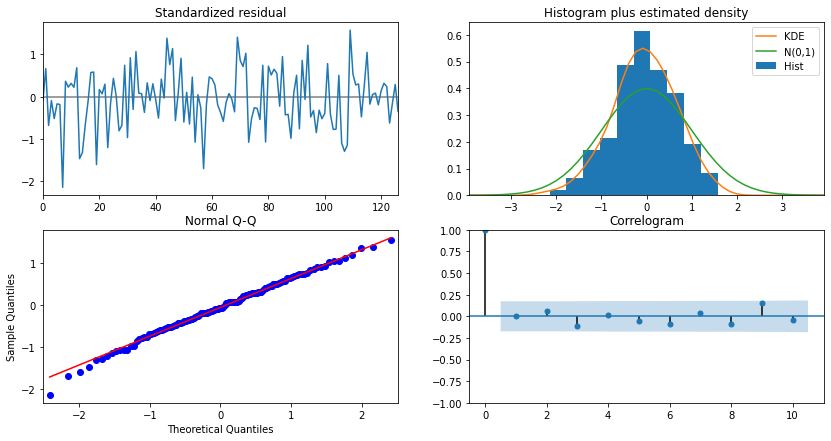

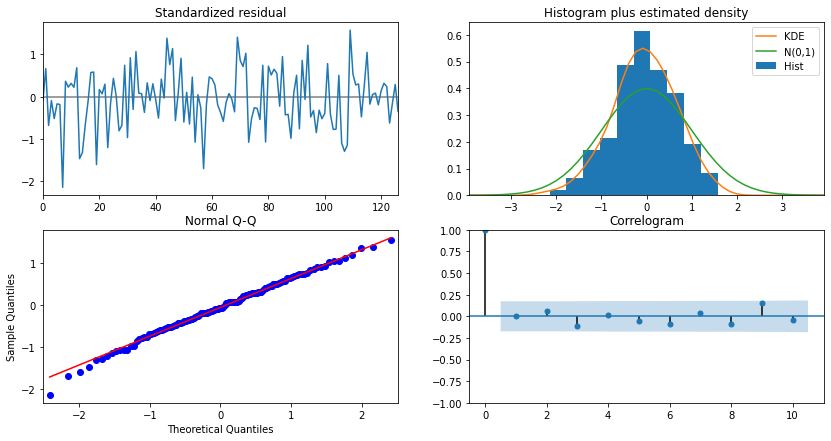

In [66]:
# Fit the model
sarima_model = SARIMAX(bal2['count'], order=(3, 1, 3), seasonal_order=(6, 1, 0, 6), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
sarima_test_df = contract_test[["count"]]
sarima_test_df['Predicted_Count'] = sarima_fit.predict(start=contract_test.index[0],
                                                 end=contract_test.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

In [67]:
# Evaluation of errors
sarima_test_df['Error'] = sarima_test_df['count'] - sarima_test_df.Predicted_Count
sarima_test_df.insert(0, 'Modelname', 'SARIMA')
sarima_test_df.head()

,Modelname,count,Predicted_Count,Error
mese-anno,,,,
2019-02,SARIMA,19251,15872.978847,3378.021153
2019-03,SARIMA,21004,20181.022751,822.977249
2019-04,SARIMA,26785,21192.327145,5592.672855
2019-05,SARIMA,20982,20386.370598,595.629402
2019-06,SARIMA,19182,18834.319753,347.680247


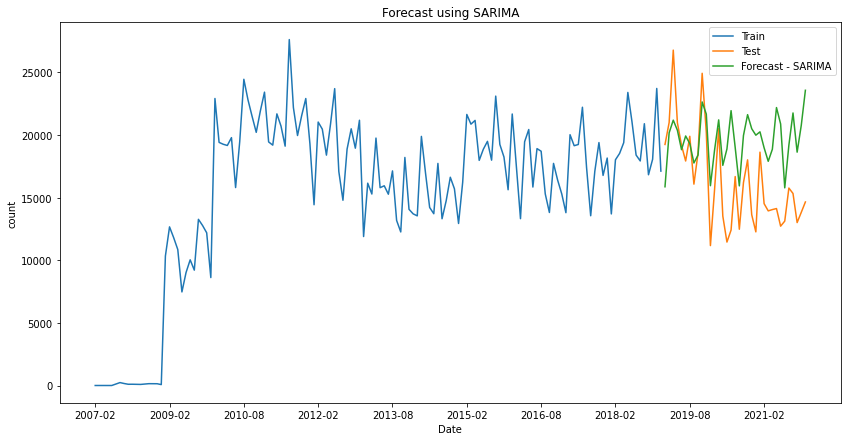

In [68]:
# Show the predictions for SARIMA model
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(sarima_test_df.index, sarima_test_df['Predicted_Count'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using SARIMA')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

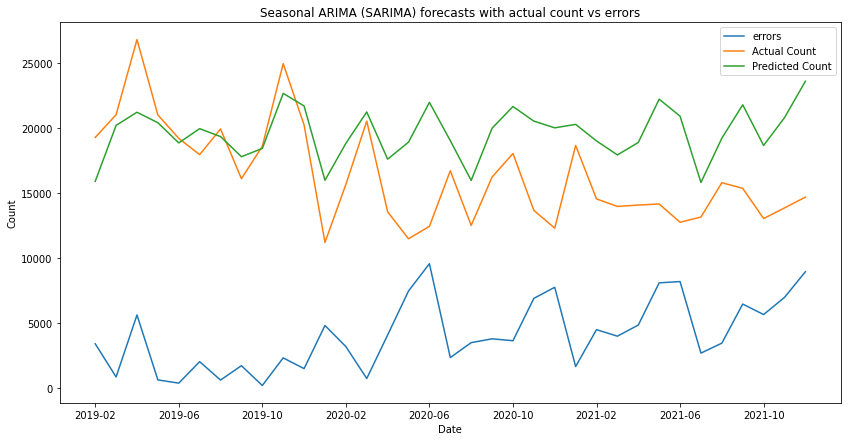

In [69]:
# Show the errors for the predicted and the actual values
plt.figure(figsize=(14,7))
plt.plot(sarima_test_df.index, np.abs(sarima_test_df['Error']), label='errors')
plt.plot(sarima_test_df.index, sarima_test_df['count'], label='Actual Count')
plt.plot(sarima_test_df.index, sarima_test_df['Predicted_Count'], label='Predicted Count')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual count vs errors')
plt.xticks(sarima_test_df.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### SVR (Support Vector Regressor)  regressor

Regression model that gives  the flexibility to define how much error is acceptable in our model and will find an appropriate line to fit the data.

In [70]:
# Start the prediction
import sklearn
svr_model = sklearn.svm.SVR(kernel='linear', degree=3, C=1.0,).fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)
print('Prediction is done...')

# Errors calculation
svr_errors_df = contract_test[['count']]
svr_errors_df['Predicted_Count'] = svr_preds
svr_errors_df['Error'] = svr_preds - y_test
svr_errors_df.insert(0, 'Modelname', 'Support Vector Regressor')
svr_errors_df.head()

Prediction is done...


,Modelname,count,Predicted_Count,Error
mese-anno,,,,
2019-02,Support Vector Regressor,19251,18702.160145,-548.839855
2019-03,Support Vector Regressor,21004,20387.782401,-616.217599
2019-04,Support Vector Regressor,26785,26107.701602,-677.298398
2019-05,Support Vector Regressor,20982,26108.374874,5126.374874
2019-06,Support Vector Regressor,19182,20367.922313,1185.922313


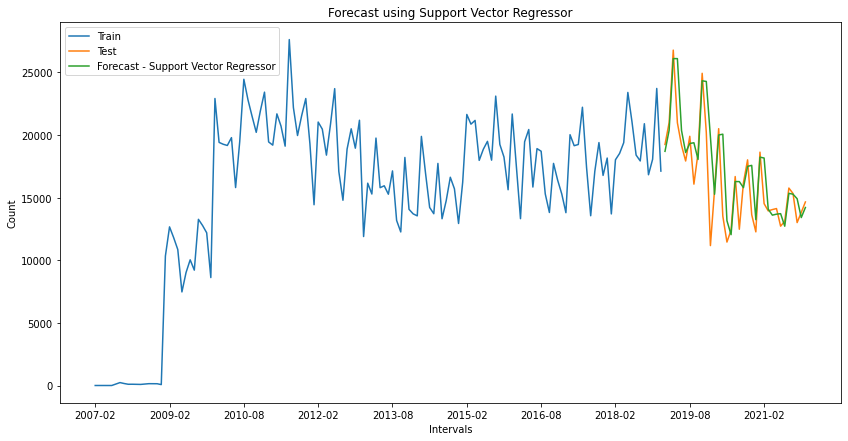

In [71]:
# Show predictions for Support Vector Regressor
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(svr_errors_df.index, svr_errors_df['Predicted_Count'], label='Forecast - Support Vector Regressor')
plt.legend(loc='best')
plt.xlabel('Intervals')
plt.ylabel('Count')
plt.title('Forecast using Support Vector Regressor')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### Compare the different models

To compare the models, we use:
* MAE: Mean Absolute Error is the average over the verification sample of the absolute values of the differences between forecast and the corresponding observation.
* RMSE: Root Mean Squared Error is the square root of the mean of the square of all of the error.
* MAPE: Mean Absolute Percentage Error is a measure of prediction accuracy of a forecasting method in statistics.

In [72]:
# Define metrics

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, count=tes_errors_df['count']):
    return np.sum(np.abs(err))/np.sum(count) * 100

In [73]:
# Calculate metrics for SVR
result_df_svr = svr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_svr

,Total_Count,Total_Pred_Count,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
Support Vector Regressor,572624,610183.910654,37559.910654,1594.609072,2562.755359,9.746591


In [74]:
# Calculate metrics for SARIMA
result_df_sarima = sarima_test_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_sarima

,Total_Count,Total_Pred_Count,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
SARIMA,572624,686507.665124,-113883.665124,4040.968893,4835.97807,24.699264


In [75]:
# Calculate metrics for Holtman Winter
result_df_hw = tes_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_hw

,Total_Count,Total_Pred_Count,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
Holtman- TES,572624,775365.110458,202741.110458,6633.272931,7887.363991,40.543979


In [76]:
# Calculate metrics for Linear regression
result_df_lr = lr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_lr

,Total_Count,Total_Pred_Count,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
Linear Regression,572624,574998.073168,2374.073168,1616.342434,2023.652828,9.87943


In [77]:
# Calculate metrics for Extra tree regression
result_df_etr = etr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_etr

,Total_Count,Total_Pred_Count,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
ExtreeTreesRegressor,572624,588189.44,15565.44,1566.148571,2253.635703,9.572634


In [78]:
# Create the table with all the previous calculated results
list_objs = [result_df_svr, result_df_lr, result_df_hw, result_df_sarima, result_df_etr]
metrics_table = pd.concat(list_objs)
metrics_table

,Total_Count,Total_Pred_Count,Model_Overall_Error,MAE,RMSE,MAPE
Modelname,,,,,,
Support Vector Regressor,572624,610183.910654,37559.910654,1594.609072,2562.755359,9.746591
Linear Regression,572624,574998.073168,2374.073168,1616.342434,2023.652828,9.879430
Holtman- TES,572624,775365.110458,202741.110458,6633.272931,7887.363991,40.543979
SARIMA,572624,686507.665124,-113883.665124,4040.968893,4835.978070,24.699264
ExtreeTreesRegressor,572624,588189.440000,15565.440000,1566.148571,2253.635703,9.572634


In [79]:
# Check of the model
print('Model Score at Train set: {:.2%}'.format(etr_model.score(X_train, y_train)))
print('Model Score at Test set: {:.2%}'.format(etr_model.score(X_test, y_test)))

Model Score at Train set: 100.00%
Model Score at Test set: 63.03%


From above metrics the "Extra Trees Regressor" model performs well, but also the Linear Regressor. 
In addition model score is not pretty accurate with (100% for Train data, 64.02% for Test data).

In [80]:
# Show Prediction of Extra Tree Regressor
etr_prediction = pd.DataFrame(data=etr_preds, columns=['Predicted_Count'])
contract_pred_test.drop(columns= ['rolling_mean','rolling_max','rolling_min'], inplace=True)
contract_pred_test.reset_index(inplace=True)
compare_results = pd.merge(contract_pred_test, etr_prediction, left_index=True, right_index=True)

In [81]:
# Compare the predictions with the real values
compare_results=compare_results.drop(columns='mese-anno')
compare_results

,count,Predicted_Count
0,19251,18794.93
1,21004,20858.85
2,26785,24259.78
3,20982,24364.33
4,19182,20750.92
5,17931,18468.14
6,19905,18556.11
7,16083,16226.41
8,18570,17406.82
9,24935,24273.43


## Pre COVID Prediction

In [82]:
# Extract only the elements of the pre COVID years
pre_covid = transformed[transformed['ANNO']<2019]
pre_covid

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
1,33,2012-07,2012,81,0,1,32591
3,61,2014-09,2014,188,0,1,32618
4,20,2014-05,2014,89,0,1,32597
5,51,2017-07,2017,53,0,1,32597
8,31,2010-03,2010,151,1,1,32597
...,...,...,...,...,...,...,...
9317598,36,2012-07,2012,89,0,0,1349
9317599,35,2011-07,2011,89,0,0,1350
9317600,27,2009-04,2009,89,0,0,1351
9317601,37,2012-06,2012,89,0,0,1349


### Balancing

In [83]:
# Check if the dataset is balanced
pre_covid["contratto_transformed"].value_counts(normalize=True)

0    0.853145
1    0.146855
Name: contratto_transformed, dtype: float64

We notice that the dataset is not balanced basing on the type of contract

In [84]:
# Count the occurencies of INDETERMINATO's contracts
pre_covid[pre_covid["contratto_transformed"]==1].count()

ETA                        1064553
mese-anno                  1064553
ANNO                       1064553
nazionalita_transformed    1064553
contratto_transformed      1064553
genere_transformed         1064553
Output_transformed         1064553
dtype: int64

In [85]:
# Count the occurencies of NON INDETERMINATO's contracts
pre_covid[pre_covid["contratto_transformed"]==0].count()

ETA                        6184457
mese-anno                  6184457
ANNO                       6184457
nazionalita_transformed    6184457
contratto_transformed      6184457
genere_transformed         6184457
Output_transformed         6184457
dtype: int64

#### Random Undersampling

We use undersampling instead of oversampling because we care more about the INDETERMINATO's contracts which have less occurencies, even if there are the possibilities to lose some informations.

In [86]:
# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = pre_covid[pre_covid["contratto_transformed"]==0].sample(n=1064553,random_state=16) 
data_1 = pre_covid[pre_covid["contratto_transformed"]==1]
balanced_pre = data_0.append(data_1)
balanced_pre

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
7742287,44,2017-04,2017,89,0,0,29368
6909111,28,2017-08,2017,89,0,0,15663
6461611,32,2012-03,2012,25,0,0,13187
5090554,54,2015-07,2015,89,0,1,31176
3867306,51,2014-06,2014,151,0,0,13785
...,...,...,...,...,...,...,...
9317558,31,2014-11,2014,70,1,0,18031
9317561,34,2012-04,2012,89,1,0,18039
9317583,28,2014-09,2014,89,1,1,18031
9317591,33,2009-01,2009,89,1,0,18036


In [87]:
# Check if the dataset is balanced
balanced_pre["contratto_transformed"].value_counts(normalize=True)

0    0.5
1    0.5
Name: contratto_transformed, dtype: float64

### Create the train and test sets

In [88]:
# Create the train and test sets
X = balanced_pre[["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"]].values
y = pd.DataFrame(balanced_pre['Output_transformed'].copy()).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [89]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
X_train=X_train.astype(np.uint8)
y_train=y_train.astype(np.uint8)

### Decision Tree

In [90]:
# Define the Decision Tree
dct = tree.DecisionTreeClassifier()
DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                           max_features=None, 
                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           class_weight=None)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [91]:
# Create Decision tree and fit it
dct.fit(X_train, y_train)

DecisionTreeClassifier()

In [92]:
# With the following sintax we will create a .dot file with the code for visualizing th tree
tree.export_graphviz(dct, out_file='tree.dot', feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"])

In [ ]:
# Show Decision tree
tree.plot_tree(dct)

In [93]:
# Probablistic prediction the values
y_pred_prob = dct.predict_proba(X_test)
y_pred_prob

array([[0.00403226, 0.00537634, 0.00806452, ..., 0.        , 0.01344086,
        0.00134409],
       [0.        , 0.        , 0.01023392, ..., 0.00292398, 0.00292398,
        0.00877193],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0034965 , 0.        , 0.        , ..., 0.0034965 , 0.        ,
        0.0034965 ],
       [0.00259516, 0.00086505, 0.00605536, ..., 0.        , 0.        ,
        0.0017301 ],
       [0.00385109, 0.        , 0.01155327, ..., 0.00385109, 0.00513479,
        0.00256739]])

In [94]:
# Predict the values
y_pred_pre = dct.predict(X_test)
y_pred_pre

array([ 90,  79,  88, ..., 136,  79,  90], dtype=uint8)

#### Confusion Matrix

In [95]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred_pre=y_pred_pre.astype(np.uint8)

# Print the confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred_pre)
print(confusion)

[[  2   3  16 ...   0  10   0]
 [  0   1  19 ...   0   7   0]
 [ 14   4 241 ...   2  18   1]
 ...
 [  5   0  25 ...   0  29   0]
 [  1   0  26 ...   0 293   0]
 [  1   4  17 ...   0  15   0]]


### ARIMA

Prediction of the number of activated contracts wiht Autoregressive integrated moving average model.

In [100]:
# Load the dataset
balanced1 = balanced_pre.copy()
balanced1 = balanced1.reset_index(drop=True)
balanced1

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
0,44,2017-04,2017,89,0,0,29368
1,28,2017-08,2017,89,0,0,15663
2,32,2012-03,2012,25,0,0,13187
3,54,2015-07,2015,89,0,1,31176
4,51,2014-06,2014,151,0,0,13785
...,...,...,...,...,...,...,...
2129101,31,2014-11,2014,70,1,0,18031
2129102,34,2012-04,2012,89,1,0,18039
2129103,28,2014-09,2014,89,1,1,18031
2129104,33,2009-01,2009,89,1,0,18036


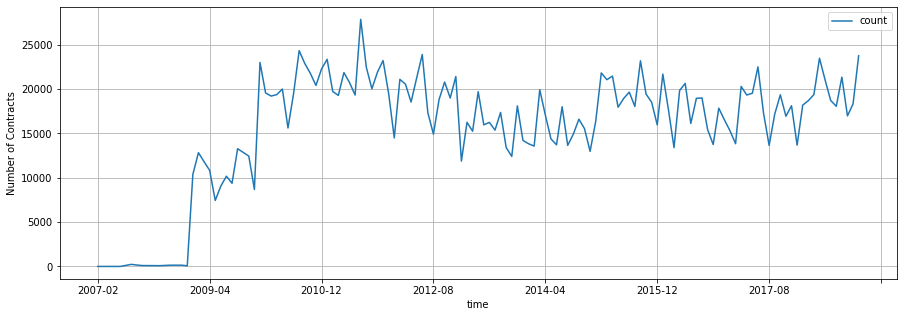

In [101]:
# Set mese-anno like index
# Show count of contract for each mese-anno
balanced2 = balanced1.groupby("mese-anno").size().reset_index(name='count')
balanced2 = balanced2.set_index('mese-anno')
f, ax1 = plt.subplots(1,1,figsize=(15,5))
balanced2.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")
plt.grid(True)

In [102]:
# Calculate the Augmented Dickey-Fuller test can be used to test for a unit root in a univariate 
#process in the presence of serial correlation.
results = adfuller(balanced2['count'])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -3.528275
p-value: 0.007290


In [103]:
# Show seasonality and trend
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(balanced2, model="additive", period=5)

fig, ax = plt.subplots(4, 1, figsize=(15, 8))
# Plot the series
decomposed_add.observed.plot(ax = ax[0])
decomposed_add.trend.plot(ax = ax[1])
decomposed_add.seasonal.plot(ax = ax[2])
decomposed_add.resid.plot(ax = ax[3])
# Add the labels to the Y-axis
ax[0].set_ylabel('')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

TypeError: ignored

In [104]:
# Search p and q values

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-5
for p in range(4):
    # Loop over q values from 0-5
    for q in range(4):
        
        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(balanced2['count'].astype(float), order=(p,1,q))
            results = model.fit()
            
            # Printing order, AIC and BIC
            #print(p, q, results.aic, results.bic)
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            #print(p, q, None, None)
            i = i+1
    
arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="aic", ascending=False, inplace=True)
arima_df

,p,q,aic,bic,sum_aic_bic
0,0,0,2604.533793,2610.359103,5214.892895
4,1,0,2593.679743,2602.417707,5196.09745
7,1,3,2578.403057,2595.878986,5174.282044
8,2,0,2577.005809,2588.656429,5165.662238
6,1,2,2575.756634,2590.319908,5166.076542
5,1,1,2575.655904,2587.306524,5162.962428
10,2,2,2575.555854,2593.031783,5168.587637
1,0,1,2575.505933,2584.243898,5159.749831
2,0,2,2574.448749,2586.099369,5160.548118
13,3,1,2573.825253,2591.301182,5165.126436


In [105]:
# Compute the model
model2 = SARIMAX(balanced2, order=(3,1,3), seasonal_order=(0,1,0,6))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             count   No. Observations:                  137
Model:             SARIMAX(3, 1, 3)x(0, 1, 0, 6)   Log Likelihood               -1251.241
Date:                           Fri, 20 May 2022   AIC                           2516.483
Time:                                   14:32:11   BIC                           2536.556
Sample:                                        0   HQIC                          2524.639
                                           - 137                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5846      0.147     -3.975      0.000      -0.873      -0.296
ar.L2         -0.7654      0.134     -5.720      0.000      -1.028      -0.503
ar.L3         -0.0415      0.138     -0.300      0.764      -0.313       0.230
ma.L1          0.1248      0.100      1.252      0.211      -0.071       0.320
ma.L2          0.1702      0.092      1.854      0.064      -0.010       0.350
ma.L3         -0.8108      0.111     -7.294      0.000      -1.029      -0.593
sigma2      1.628e+07   2.19e-09   7.45e+15      0.000    1.63e+07    1.63e+07
===================================================================================
Ljung-Box (Q):                       66.91   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               0.82   Skew:                             0.13
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.39e+31. Standard errors may be unstable.
"""

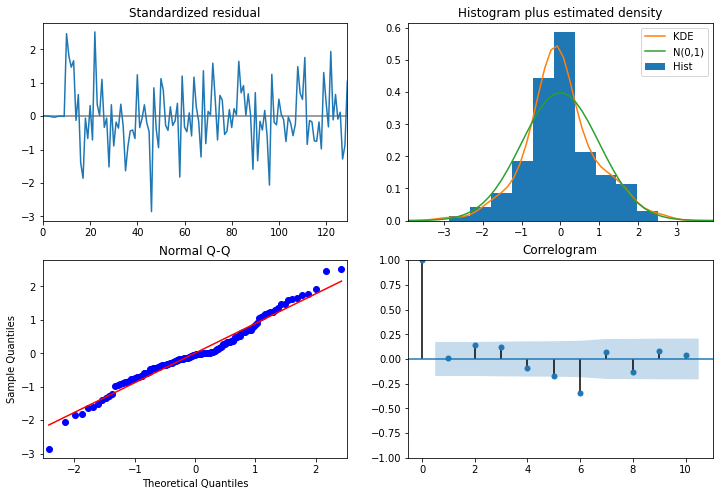

In [106]:
# Show the parameters
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()

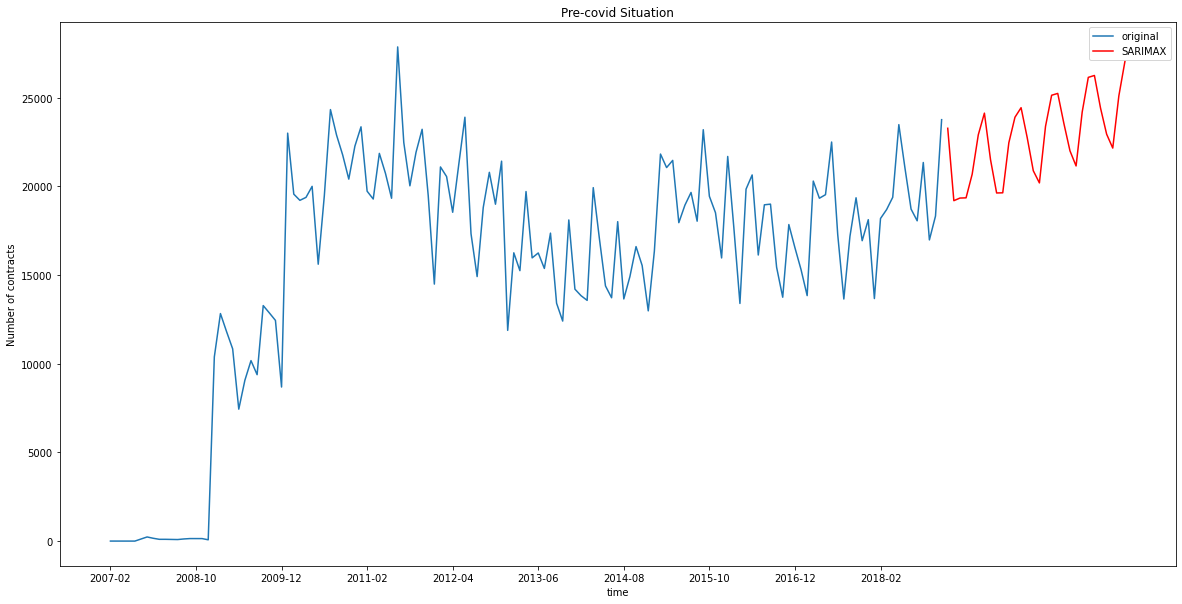

In [107]:
# Prediction of the future

# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(balanced2, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")

plt.xticks(balanced2.index.unique())
plt.locator_params(axis='x', nbins=10)

plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.title('Pre-covid Situation')
plt.legend()
plt.show()

#### Pre vs Post COVID

In [108]:
# Extract only the elements of the post COVID years
post_covid = transformed[transformed['ANNO']>=2019]
post_covid

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
0,60,2020-05,2020,188,0,1,32612
2,45,2019-04,2019,89,0,1,32612
6,51,2020-07,2020,144,0,1,32597
7,42,2020-03,2020,89,0,1,32597
10,27,2020-07,2020,25,0,0,32618
...,...,...,...,...,...,...,...
9317560,24,2021-04,2021,89,0,1,18031
9317563,28,2019-12,2019,89,1,0,18034
9317580,24,2020-04,2020,89,0,0,18031
9317581,26,2019-02,2019,89,1,1,18030


##### Balancing

In [109]:
# Check if the dataset is balanced
post_covid["contratto_transformed"].value_counts(normalize=True)

0    0.861056
1    0.138944
Name: contratto_transformed, dtype: float64

In [110]:
# Count the occurencies of INDETERMINATO's contracts
post_covid[post_covid["contratto_transformed"]==1].count()

ETA                        287419
mese-anno                  287419
ANNO                       287419
nazionalita_transformed    287419
contratto_transformed      287419
genere_transformed         287419
Output_transformed         287419
dtype: int64

In [111]:
# Count the occurencies of NON INDETERMINATO's contracts
post_covid[post_covid["contratto_transformed"]==0].count()

ETA                        1781174
mese-anno                  1781174
ANNO                       1781174
nazionalita_transformed    1781174
contratto_transformed      1781174
genere_transformed         1781174
Output_transformed         1781174
dtype: int64

###### Random Undersampling

In [112]:
# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = post_covid[post_covid["contratto_transformed"]==0].sample(n=287419,random_state=16) 
data_1 = post_covid[post_covid["contratto_transformed"]==1]
balanced_covid = data_0.append(data_1)
balanced_covid

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
4626835,24,2019-01,2019,89,0,1,13991
8664487,50,2021-01,2021,89,0,0,17999
1860233,56,2020-08,2020,89,0,1,17317
8887500,28,2019-04,2019,89,0,1,2600
9167550,20,2020-12,2020,89,0,1,17403
...,...,...,...,...,...,...,...
9317543,46,2021-08,2021,89,1,1,18031
9317556,31,2021-12,2021,89,1,1,18031
9317563,28,2019-12,2019,89,1,0,18034
9317581,26,2019-02,2019,89,1,1,18030


In [113]:
# Check if the dataset is balanced
balanced_covid["contratto_transformed"].value_counts(normalize=True)

0    0.5
1    0.5
Name: contratto_transformed, dtype: float64

##### Prediction

Text(0, 0.5, 'Number of Contracts')

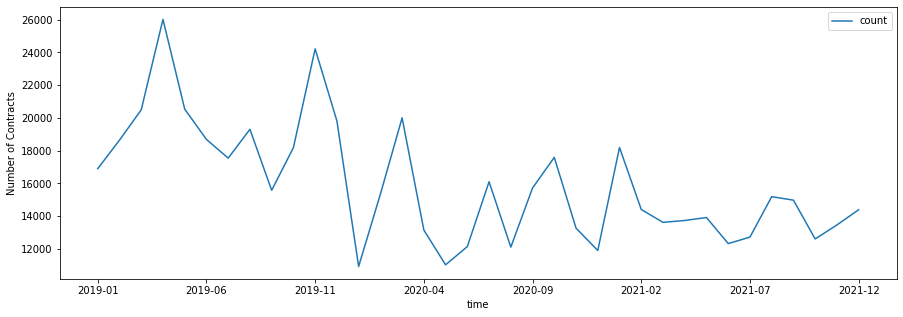

In [114]:
# Set mese-anno like index
# Show count of contract for each mese-anno
balanced_covid1 = balanced_covid.groupby("mese-anno").size().reset_index(name='count')
balanced_covid1 = balanced_covid1.set_index('mese-anno')
f, ax1 = plt.subplots(1,1,figsize=(15,5))
balanced_covid1.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")

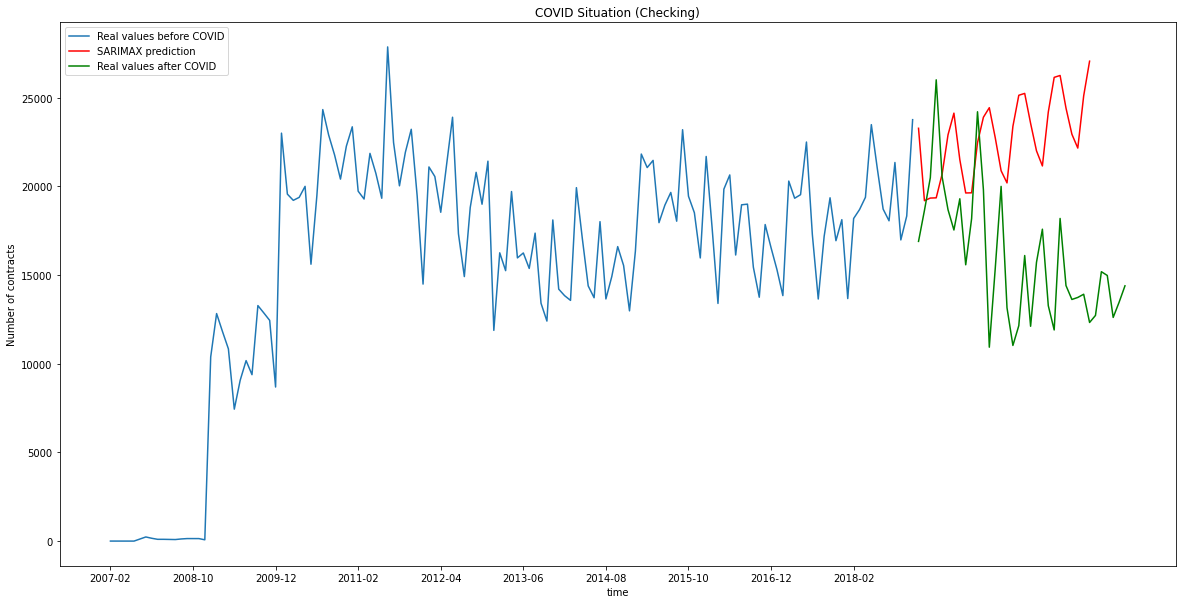

In [115]:
# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(balanced2, label='Real values before COVID')
plt.plot(forecast.predicted_mean, label='SARIMAX prediction', c="r")
plt.plot(balanced_covid1, label='Real values after COVID', c='g')
plt.xticks(balanced2.index.unique())
plt.locator_params(axis='x', nbins=10)

plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.title('COVID Situation (Checking)')
plt.legend()
plt.show()

#### Results

As we can see in the graph, the COVID situation led to decrease in the number of contracts, compared to the prediction based on data through 2019. 